## Домашнє завдання № 11

В якості домашнього завдання вам пропонується створити рекурентну нейронну мережу за допомогою механізмів Keras, яка буде класифікувати рецензії із датасету imdb.   



На відміну від прикладу в модулі 9 ми використаємо рекурентну нейронну мережу. Поекспериментуйте з будовою мережі - RNN, LSTM, двостороння та глибока.   



Порівняйте результати та зробіть висновки.   

In [5]:
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import pad_sequences, set_random_seed
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, Bidirectional, Dropout

## Встановлюємо гіперпараметри

In [6]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів

In [7]:
from keras.datasets import imdb

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features) # Завантаженн даних


## Опис датасету IMDB   
Датасет IMDB являє собою набір відгуків про фільми з сайту Internet Movie Database (IMDB).  

Дані (input): Це послідовності індексів слів, що представляють тексти відгуків про фільми. Кожен елемент у датасеті являє собою один відгук. Наприклад, train_data[0] містить послідовність індексів для першого відгуку.   
Мітки (y): Це бінарні значення (0 або 1), що представляють собою негативний або позитивний відгук. Наприклад,   train_labels[0] містить мітку (0 або 1) для першого відгуку, вказуючи на те, негативний це відгук чи позитивний.  
Приклади:   

train_data[0]: [1, 14, 22, 16, 43, ...] (послідовність індексів слів першого відгуку) train_labels[0]: 1 (мітка, що вказує на позитивний відгук)    

Для декодування цих індексів назад у слова, можна використати словник imdb.get_word_index(), що надається Keras.    

## Розміри датасета 
Тренувальний датасет:   
Розмір тренувальних даних: (25000,) Розмір міток тренувальних даних: (25000,)   
Тестовий датасет:   
Розмір тестових даних: (25000,) Розмір міток тестових даних: (25000,)

In [8]:
# Декодуємо відгук

def decode_review(numberlist: list):
    word_to_id = imdb.get_word_index()
    word_to_id = {k: (v + 3) for k, v in word_to_id.items()}
    # word_to_id["<PAD>"] = 0
    # word_to_id["<START>"] = 1
    # word_to_id["<UNK>"] = 2
    # word_to_id["<UNUSED>"] = 3
    word_to_id = {v: k for k, v in word_to_id.items()}
    id_to_word = [
        word_to_id.get(word) for word in numberlist if word not in range(0, 3)
    ]
    return " ".join(id_to_word)

In [9]:
index = 1
print(f"Відгук: {input_train[index]}")
print(f"Декодований: {decode_review(input_train[index])}")
print(f"Мітка: {y_train[index]}")

Відгук: [1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]
Декодований: big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've s

In [10]:
x_train = pad_sequences(input_train, maxlen=maxlen)
x_test = pad_sequences(input_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

## Побудова моделей

В нашому випадку порівнюємо LSTM layer і SimpleRNN layer .    
Для порівняння моделі створимо з однаковим числом шарів, та з однаковими параметрами.


In [11]:
class BaseModel:
    def __init__(self, name, max_features, layer):
        self.name = name
        self.max_features = max_features
        self.build = self.build_model(layer)

    def build_model(self, layers: list):
        model = Sequential()
        model.add(Embedding(self.max_features, 64))
        for layer in layers:
            model.add(layer)
        model.add(Dropout(0.4))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
        return model


class SimpleRNNModel(BaseModel):
    def __init__(self, name="SRNN", max_features=max_features):
        super().__init__(name, max_features, [SimpleRNN(units=64)])


class LSTMModel(BaseModel):
    def __init__(self, name="LSTM", max_features=max_features):
        super().__init__(name, max_features, [LSTM(units=64)])


class BidirectionalRNNModel(BaseModel):
    def __init__(self, name="Bidirectional_SRNN", max_features=max_features):
        super().__init__(name, max_features, [Bidirectional(SimpleRNN(units=64))])


class BidirectionalLSTMModel(BaseModel):
    def __init__(self, name="Bidirectional_LSTM", max_features=max_features):
        super().__init__(
            name,
            max_features,
            [
                Bidirectional(LSTM(units=64)),
            ],
        )

## Створення наших  моделей 

In [12]:
models = []

for model_class in [
    SimpleRNNModel,
    BidirectionalRNNModel,
    LSTMModel,
    BidirectionalLSTMModel,
]:
    model_instance = model_class()
    models.append(model_instance)

## Навчання моделей

In [13]:
epochs = 5
batch_size = 2**6

In [14]:
models_info = {}
set_random_seed(42)

for model in models:
    print(f"\nStart learning model: {model.name}\n")
    model.build.summary()

    start_time = time.time()
    history = model.build.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.3,
        verbose=1,
    )
    end_time = time.time()

    # Додаємо історію, та час навчання до словника
    models_info.setdefault(model.name, {})["history"] = history
    models_info[model.name]["edu_time"] = round(end_time - start_time, 2)

    start_time = time.time()
    test_loss, test_acc = model.build.evaluate(x_test, y_test)
    end_time = time.time()

    # Визначаємо функцію втрат та точність на тестових даних
    print(f"Test Loss: {test_loss:.2f}")
    print(f"Test Accuracy: {test_acc:.2f}")
    models_info[model.name]["test_loss"] = round(test_loss, 2)
    models_info[model.name]["test_acc"] = round(test_acc, 2)
    models_info[model.name]["eval_time"] = round(end_time - start_time, 2)


Start learning model: SRNN



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 61s 207ms/step - acc: 0.5430 - loss: 0.6853 - val_acc: 0.7541 - val_loss: 0.5074
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 87s 319ms/step - acc: 0.7948 - loss: 0.4566 - val_acc: 0.7941 - val_loss: 0.4581
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - acc: 0.8487 - loss: 0.3585 - val_acc: 0.8284 - val_loss: 0.4215
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 56s 204ms/step - acc: 0.8854 - loss: 0.2863 - val_acc: 0.8195 - val_loss: 0.4386
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 93s 243ms/step - acc: 0.9321 - loss: 0.1855 - val_acc: 0.8359 - val_loss: 0.4911
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - acc: 0.8309 - loss: 0.5005
Test Loss: 0.50
Test Accuracy: 0.83

Start learning model: Bidirectional_SRNN



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 132s 409ms/step - acc: 0.5069 - loss: 0.7029 - val_acc: 0.5275 - val_loss: 0.7036
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 112s 408ms/step - acc: 0.6485 - loss: 0.6213 - val_acc: 0.7268 - val_loss: 0.5421
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 135s 380ms/step - acc: 0.7831 - loss: 0.4719 - val_acc: 0.7567 - val_loss: 0.5096
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 107s 389ms/step - acc: 0.8448 - loss: 0.3756 - val_acc: 0.8264 - val_loss: 0.4231
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 99s 361ms/step - acc: 0.8629 - loss: 0.3294 - val_acc: 0.8236 - val_loss: 0.4340
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - acc: 0.8297 - loss: 0.4319
Test Loss: 0.43
Test Accuracy: 0.83

Start learning model: LSTM



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 125s 431ms/step - acc: 0.6093 - loss: 0.6367 - val_acc: 0.8289 - val_loss: 0.4040
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 119s 435ms/step - acc: 0.8289 - loss: 0.3970 - val_acc: 0.8531 - val_loss: 0.3560
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 122s 444ms/step - acc: 0.8758 - loss: 0.3138 - val_acc: 0.8759 - val_loss: 0.3064
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 115s 420ms/step - acc: 0.8945 - loss: 0.2811 - val_acc: 0.8779 - val_loss: 0.2974
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 138s 505ms/step - acc: 0.9089 - loss: 0.2466 - val_acc: 0.8812 - val_loss: 0.3028
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - acc: 0.8758 - loss: 0.3166
Test Loss: 0.31
Test Accuracy: 0.88

Start learning model: Bidirectional_LSTM



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 271s 944ms/step - acc: 0.5816 - loss: 0.6569 - val_acc: 0.8083 - val_loss: 0.4362
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - acc: 0.8190 - loss: 0.4173 - val_acc: 0.8513 - val_loss: 0.3611
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - acc: 0.8657 - loss: 0.3314 - val_acc: 0.8745 - val_loss: 0.3114
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - acc: 0.8854 - loss: 0.2967 - val_acc: 0.8803 - val_loss: 0.3006
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 264s 963ms/step - acc: 0.9011 - loss: 0.2611 - val_acc: 0.8773 - val_loss: 0.3051
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - acc: 0.8766 - loss: 0.3117
Test Loss: 0.31
Test Accuracy: 0.88


### Візуалізація кривих навчання

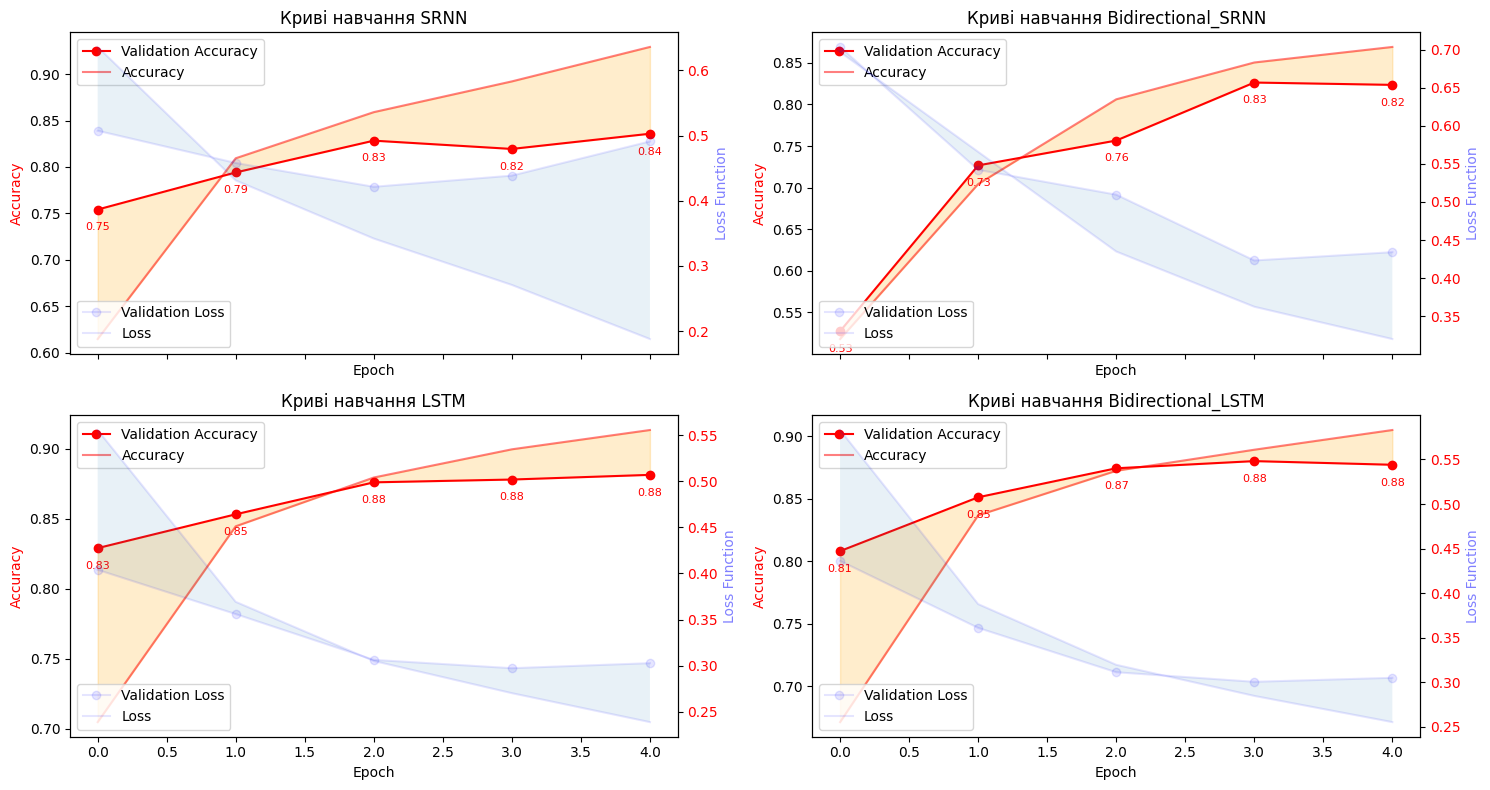

In [15]:
fig, axs = plt.subplots(
    len(models_info) // 2, 2, figsize=(15, 4 * (len(models_info) // 2)), sharex=True
)

for i, (model_name, model_info) in enumerate(models_info.items()):
    history = model_info["history"]

    row = i // 2
    col = i % 2

    ax1 = axs[row, col]

    val_loss = history.history["val_loss"]
    loss = history.history["loss"]
    val_accuracy = history.history["val_acc"]
    accuracy = history.history["acc"]

    ax1.plot(val_accuracy, label="Validation Accuracy", marker="o", color="r")
    ax1.plot(accuracy, label="Accuracy", color="r", alpha=0.5)
    ax1.fill_between(
        range(len(accuracy)), accuracy, val_accuracy, color="orange", alpha=0.2
    )
    ax1.tick_params(labelcolor="k")
    ax1.legend(loc="upper left")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy", color="r")

    for j, acc in enumerate(val_accuracy):
        ax1.annotate(
            f"{acc:.2f}",
            (j, acc),
            textcoords="offset points",
            xytext=(0, -15),
            ha="center",
            c="r",
            fontsize=8,
        )

    ax2 = ax1.twinx()

    ax2.plot(val_loss, label="Validation Loss", marker="o", color="b", alpha=0.1)
    ax2.plot(loss, label="Loss", color="b", alpha=0.1)
    ax2.set_ylabel("Loss Function", color="b", alpha=0.5)
    ax2.fill_between(range(len(loss)), loss, val_loss, alpha=0.1)

    ax2.tick_params(axis="y", labelcolor="r")
    ax2.grid(True, linestyle="--")

    ax2.legend(loc="lower left")

    plt.grid()
    plt.title(f"Криві навчання {model_name}")

plt.tight_layout()
plt.savefig(f"training_curves_epochs_{epochs}_batch_{batch_size}.pdf")
plt.show()

### Результати навчання наших моделей

In [16]:
import pandas as pd

df = pd.DataFrame(models_info)

# Deleting the column 'history'
df = df.drop("history", axis=0,).transpose()

df

,edu_time,test_loss,test_acc,eval_time
SRNN,356.45,0.5,0.83,39.3
Bidirectional_SRNN,584.1,0.43,0.83,44.26
LSTM,619.34,0.31,0.88,73.52
Bidirectional_LSTM,1529.37,0.31,0.88,73.13


In [17]:
df.to_csv(f"data_epochs_{epochs}_batch_{batch_size}.csv", index=True, sep=" ")

### Графіки резулльтатів для наочного порівння 

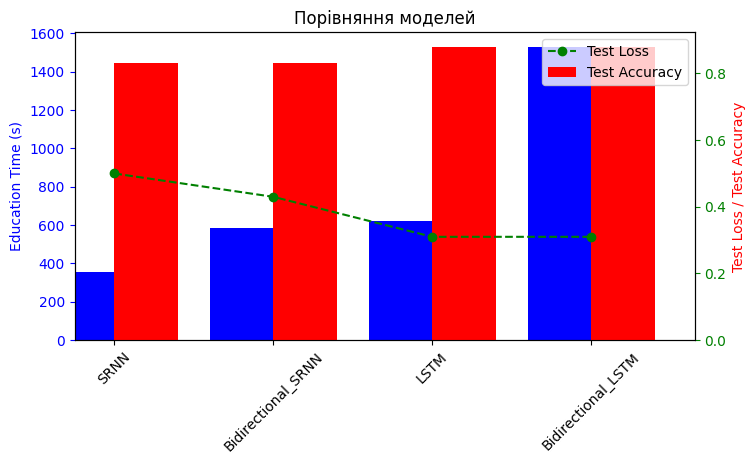

In [18]:
fig, ax1 = plt.subplots(figsize=(8, 4))

df["edu_time"].plot(kind="bar", ax=ax1, position=1, color="b", width=0.4)
ax1.set_ylabel("Education Time (s)", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
df["test_acc"].plot(kind="bar", ax=ax2, position=0, color="r", width=0.4)
df["test_loss"].plot(kind="line", ax=ax2, color="g", linestyle="--", marker="o")

ax2.set_ylabel("Test Loss / Test Accuracy", color="r")
ax2.tick_params("y", colors="g")
ax1.set_xticklabels(df.index, rotation=45)
plt.title("Порівняння моделей")
plt.legend(["Test Loss", "Test Accuracy"], loc="upper right")
plt.savefig(f"model_comparison_epochs_{epochs}_batch_{batch_size}.pdf")
plt.show()

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")


all_predictions = []
for model in models:
    y_pred = model.build.predict(x_test)
    y_pred = y_pred > 0.5
    all_predictions.append(y_pred)

782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 111ms/step


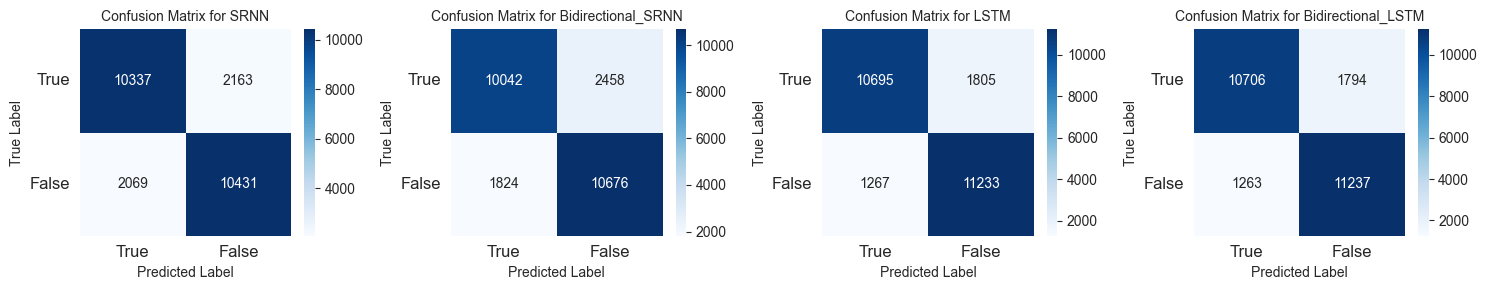

In [21]:
# Створення фігури(графіку)
fig, axs = plt.subplots(1, len(models), figsize=(15, 3), squeeze=False)

#  Обрахунок матриць помилок для кожної моделі 
for i, model in enumerate(models):
    cm = confusion_matrix(y_test, all_predictions[i])

    df1 = pd.DataFrame(columns=["True", "False"], index=["True", "False"], data=cm)

    sns.heatmap(df1, annot=True, cmap="Blues", fmt=".0f", ax=axs[0, i])
    axs[0, i].set_xlabel("Predicted Label")
    axs[0, i].tick_params(axis="x", labelsize=12)
    axs[0, i].tick_params(axis="y", labelsize=12, rotation=0)
    axs[0, i].set_ylabel("True Label")
    axs[0, i].set_title(f"Confusion Matrix for {model.name}", size=10)

plt.tight_layout()
plt.savefig(f"convolution_matrix_epochs_{epochs}_batch_{batch_size}.pdf")
plt.show()

## Висновки
Експерименти проводились для кількості епох: 5, 10 та 15.

За результатами навчання можна зробити висновок що починаючи з 5 епохи спостерігається суттєве перенавчання .
 Ускладнювати архітектуру мережі я не став, оскільки на це потрібно багато машинного часу, хоча в коді класу моделі я таку можливість передбачив:  

def __init__(self, name="SRNN", max_features=max_features):
        super().__init__(name, max_features, [
         SimpleRNN(units=64),
         # сюди можна додавати шари
         ])   
 Отож за основу аналізу результатів взято навчання на 5-ти епохах. 
На такому числі епох для простих архітектур RNN  вже можна зробити певні висновки:   

1. Моделі LSTM показують крашу точність ніж прості рекурентні мережі SimpleRNN, однак значно довше навчання.   

Можливі причини:     

Проблема простих рекурентних нейронних мереж, таких як SimpleRNN, полягає в тому, що вони стикаються з проблемою затухаючого градієнта під час навчання на довгих послідовностях даних. Це може призвести до труднощів у вловлюванні довгострокових залежностей, що особливо важливо для задач аналізу сентименту, де важливим є контекст усього речення або навіть абзацу.    

2. LSTM має механізм управління пам'яттю, який дозволяє їй зберігати інформацію на тривалих часових інтервалах. Це робить її більш здатною до обробки текстових даних, де важливі залежності на різних рівнях контексту.    

Двонапрямлені мережі показують дещо гірші результати ніж однонапрямлені. Крім того, вони вимагають більшого часу навчання.    

Скоріш за все в сентиментальному аналізі двонаправленість не відіграє такої ролі, як в задачах машинного перекладу, а отримані результати можна вважати однаковими в межах похибки для точності    
. Таку точність можна оцінити з результатів проведених мною експериментів.